## Load Functions and Libraries

In [2]:
%run "../../lib/init_py.py"

Root project dir is: /Users/Luqman/Documents/Projects/ledecision


In [3]:
from lib.functions import *
from bs4 import BeautifulSoup
import urllib
import codecs
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import datetime
import pyarrow.parquet as pq
import pyarrow as pa

## Connect to DB, load data and convert to dataframe

In [4]:
db_path = "../../data/01_raw/ledb.db"

In [5]:
conn = sqlite3.connect(db_path)
c = conn.cursor()

In [6]:
c.execute('SELECT SQLITE_VERSION()')

In [7]:
c.execute('SELECT * FROM tweets')
raw_data = c.fetchall()

In [8]:
conn.close()

In [9]:
raw_df = pd.DataFrame(raw_data)
raw_df.columns = ['text', 'username', 'date', 'location']

In [10]:
# clear raw data list
del raw_data

In [22]:
raw_df[160:165]

NameError: name 'raw_df' is not defined

In [12]:
print(raw_df.dtypes)

text        object
username    object
date        object
location    object
dtype: object


In [13]:
raw_df['date'] = pd.to_datetime(raw_df['date'])

## Clean Data

In [14]:
test_df = raw_df

In [15]:
import re

def tweet_cleaner(s):    
    s = re.sub(r"http\S+", "", s)
    s = s.replace("’", "")
    s = s.replace("'", "")
    s = s.replace("amp", "")
    s = re.sub(r"\s*[^A-Za-z]+\s*", " ", s)
    s = s.lower()
    return s

testing = raw_df.text[:]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [16]:
# Combine into dataframe
test = pd.DataFrame(test_result)
test.columns = ['text']
clean_df = pd.concat([test, test_df['username'], test_df['date'], test_df['location']], axis=1)

In [17]:
test_df = clean_df
clean_df = test_df[test_df.text.str.contains('lebron')]

In [18]:
del testing, test_result

In [19]:
del raw_df, test_df, test

In [20]:
clean_df.head()

,text,username,date,location
0,will la mean lebron behind the scenes and on t...,wireless4k,2018-07-04 05:10:15,"Las Vegas, NV"
1,utai live josh hearts lebron,TheodoreGreek,2018-07-04 05:10:10,"Salt Lake City, UT"
2,therockparmar the celtics big was washed kobe...,DaysofCondor,2018-07-04 05:10:10,
3,evantmack jessklein monsebolanos yea i know l...,JamesJordan54,2018-07-04 05:10:09,
4,lebron diva shit has already happen jesus chri...,GuruBanks,2018-07-04 05:10:08,


## Count data

### Tweets per minute

In [162]:
sdate = datetime.datetime(2018,6,30,23,0,0)
edate = datetime.datetime(2018,7,2,23,0,0)
#edate = datetime.datetime(2018,7,1,23,0,0)
date_df = []
date_df.append(sdate)

date = sdate
while date < edate:
    date += datetime.timedelta(minutes=1)
    date_df.append(date)

In [163]:
tweet_count = []
for i in range(0,len(date_df)-1):
    mask = (clean_df['date'] <= date_df[i+1]) & (clean_df['date'] > date_df[i])
    tweet_count.append(len(clean_df.loc[mask]))

tweet_count.append(0)

In [164]:
len(tweet_count)

2881

In [ ]:
# Plot tweets per minute
x = range(0,len(tweet_count))
plt.scatter(x, temp,s=1)
plt.show()

In [ ]:
tweet_per_min = pd.DataFrame(
    {
        'date': date_df,
        'tcount': tweet_count
    })

In [ ]:
output_file = "../../data/02_intermediate/tweet_count.csv"
tweet_per_min.to_csv(output_file, sep='\t')

## Export cleaned tweets

In [24]:
table = pa.Table.from_pandas(clean_df)
pq.write_table(table, "../../data/02_intermediate/tweets1.parquet")

In [23]:
clean_df[160:165]

,text,username,date,location
161,thebryaan i dont understand how its a bandwag...,Daviddd021,2018-07-04 05:02:16,Paradise
162,so over all the lebron to the lakers news but ...,reneemcdonald,2018-07-04 05:02:16,Southern California
164,bportistime lebron fans are x worse,MLG_Mahal,2018-07-04 05:01:57,"Chicago, IL"
165,i liked a youtube video colin cowherd on warri...,BrucePein,2018-07-04 05:01:56,"New York, USA"
166,bleacherreport espn whatever all he had to do...,commishJCA,2018-07-04 05:01:56,Dodger Blue in New York


In [166]:
output_file = "../../data/02_intermediate/tweets.csv"
clean_df.to_csv(output_file, sep='\t')

## Sanity Analysis

## Word cloud

In [ ]:
#!/usr/bin/env python
"""
Minimal Example
===============
Generating a square wordcloud from the US constitution using default arguments.
"""

from os import path
from wordcloud import WordCloud

#d = path.dirname(__file__)

# Read the whole text.
text = open(path.join('./example.txt')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
#image.show()

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

sentdata = pd.DataFrame(columns=['neg', 'neu', 'pos', 'compound'])
        
test = clean_df.text[:]

for sentence in test:
    ss = sid.polarity_scores(sentence)
    sentdata = sentdata.append(pd.DataFrame(ss, index=[0]))
#     for k in sorted(ss):
#         print('{0}: {1}, '.format(k, ss[k]), end='')
#         print()

In [18]:
del test

## Graphing

In [35]:
test = sentdata.query('compound != 0.0000')

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# plotdata = pd.concat([clean_df['date'], sentdata['compound']], axis=1)
#plotdata = plotdata[plotdata.compound != 0]

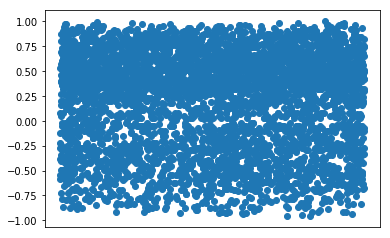

In [74]:
import numpy as np
import matplotlib.pyplot as plt

tlength = 5000

ind = np.arange(tlength)

plt.scatter(ind,test['compound'][:tlength])

frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.show()

### Data with time

In [76]:
test_df = clean_df

In [77]:
test_df['date'] = pd.to_datetime(test_df['date'])  

In [78]:
test_df[:10]

,text,username,date,location
0,imagine the possibilities of a lineup includi...,SugeW,2018-06-30 12:49:33,Delaware
1,reasonssports michaelryanruiz all the praise ...,SuperJamono,2018-06-30 12:49:33,
2,ladies dont date a guy who follows lebron to e...,Mr_CEO_BTRAIN,2018-06-30 12:49:30,Uhrichsville ➡️ Akron
3,lebron james business ventures howard mitchell...,hmitchell535,2018-06-30 12:49:28,
4,forget the lakers and the cavs lebron should s...,sportsbyfry,2018-06-30 12:49:26,Canada
5,drew carmichaeldave i disagree about it being...,OldTakesExposed,2018-06-30 12:49:26,"West Palm Beach, FL"
6,darrendreger it would be lebron signing with ...,DarylJay62,2018-06-30 12:49:23,Toronto Ontario Canada
7,the streets is watching hip hop proverb,GrandStCentral,2018-06-30 12:49:11,"Toronto, Ontario"
8,jemelehill i know all of you think that once ...,Jreid1997,2018-06-30 12:49:10,United States
9,billsimmons the knicks go for at least billio...,brianfreeog,2018-06-30 12:49:06,


In [84]:
mask = (test_df['date'] <= '2018-06-30 09:00:00') & (test_df['date'] > '2018-06-30 08:00:00')
print(test_df.loc[mask])

                                                   text         username  \
1899  i love that lebron is changing the dynamic of ...   carbocommander   
1900  lebron james weighing many options as free age...         nbariver   
1901   goat szn chinkyeyedmike demidrange youre a le...    Dangitbfousey   
1902   optic scumper you do realize that lebron has ...     trodriguez82   
1903   thejonasknox maybe the pregnancy test compani...     IAmSuchADope   
1904  nba notebook lebron reportedly opting out beco...         nbariver   
1905  also ive been saying this for over a year now ...  andrew_gormley4   
1906   heartsunity hunterrob b ingramdagoat nbaontnt...        VipersLoL   
1907  real basketball fans know that nothing was bet...      rollie_rexx   
1908                         lebron is coming to philly   carbocommander   
1909   nba free agency what lebron james opting out ...         akmm1292   
1910  what the cavaliers should do if lebron james l...         akmm1292   
1911  lebron

In [89]:
len(test_df.loc[mask])

339